<a href="https://colab.research.google.com/github/jason96819/Project_1/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EB%AA%A8%EB%8D%B8%ED%95%99%EC%8A%B5_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

라이브러리 import

In [1]:
pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 44.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
from collections import Counter
from konlpy.tag import Kkma
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
%matplotlib inline

사용한 모델 : BiLSTM

사용한 데이터셋 : 한국어 스팀 리뷰

데이터 확인 및 전처리

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x7ae606ee6d70>)

In [4]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data))

전체 리뷰 개수 : 100000


In [5]:
total_data[:5]

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [7]:
total_data['reviews'].nunique(), total_data['label'].nunique()                                                                          # 중복확인

(99892, 2)

In [8]:
total_data.drop_duplicates(subset=['reviews'], inplace=True)                                                                        # 중복 샘플 제거
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 99892


In [9]:
total_data.isnull().sum()                                                                                                                               # null 확인

label      0
reviews    0
dtype: int64

훈련 데이터와 테스트 데이터 분리하기

In [10]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 77)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 74919
테스트용 리뷰의 개수 : 24973


레이블의 분포 확인

<Axes: >

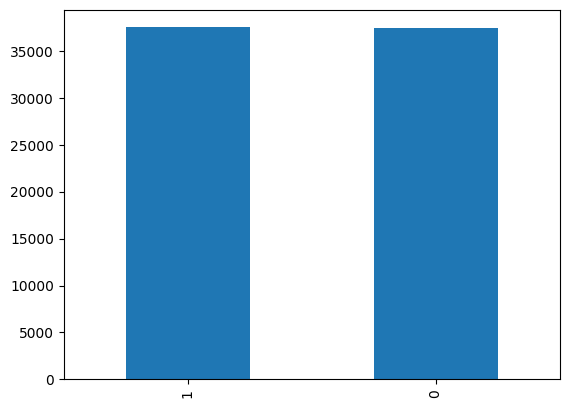

In [11]:
train_data['label'].value_counts().plot(kind = 'bar')

0 : 부정

1 : 긍정

In [12]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  37407
1      1  37512


In [13]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

label      0
reviews    0
dtype: int64


<ipython-input-13-5c91c21161d5>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [14]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

In [15]:
okt = Okt()

In [16]:
train_data['tokenized'] = train_data['reviews'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

단어와 길이 분포 확인하기

In [17]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [18]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('안', 3967), ('로', 3722), ('너무', 3425), ('못', 3104), ('으로', 3048), ('하고', 2547), ('할', 2395), ('개', 2227), ('적', 2172), ('그냥', 2133), ('시간', 2124), ('하는', 2105), ('거', 2081), ('것', 2035), ('왜', 2026), ('에서', 2017), ('플레이', 1977), ('나', 1952), ('좀', 1899), ('사람', 1795)]


In [19]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('로', 3517), ('으로', 3435), ('할', 2685), ('플레이', 2646), ('시간', 2441), ('입니다', 2398), ('것', 2333), ('너무', 2285), ('적', 2276), ('추천', 2275), ('하는', 2257), ('때', 2245), ('좀', 2145), ('갓', 2137), ('수', 2064), ('안', 2063), ('하고', 2018), ('에서', 1907), ('하면', 1878), ('생각', 1849)]


긍정 리뷰의 평균 길이 : 13.153897419492429
부정 리뷰의 평균 길이 : 13.519501697543241


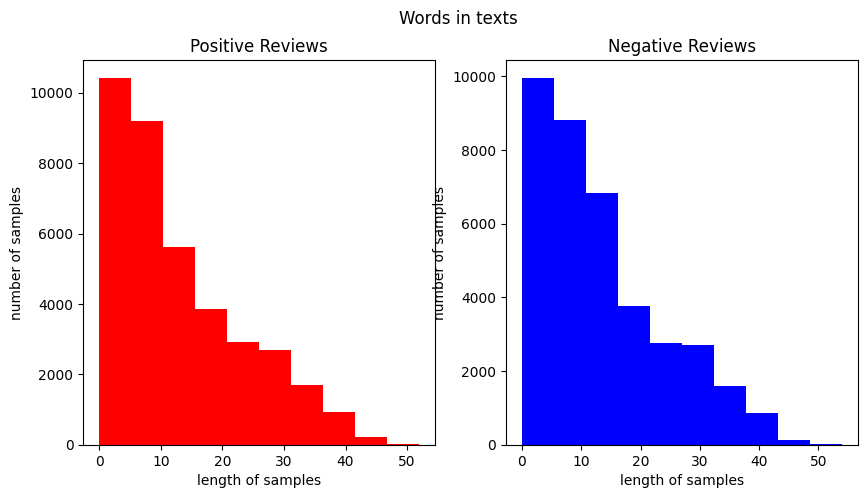

In [20]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [21]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

정수 인코딩

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [23]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69600
등장 빈도가 1번 이하인 희귀 단어의 수: 37928
단어 집합에서 희귀 단어의 비율: 54.49425287356322
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.796015224895487


In [24]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 31674


In [25]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [26]:
print(X_train[:3])

[[1487], [1138, 233, 2281, 4779, 17, 38, 7124, 1587, 879, 1138, 31, 750, 8504, 1138, 233, 4779, 1588, 1138, 31, 463, 3243, 6145], [110, 303, 677, 1557, 101, 1, 165, 1, 54, 331, 7980, 22425, 10, 1, 5083, 366, 1055, 835, 2931, 1757, 260, 5283, 168, 110, 1901, 9125, 5084, 1772, 9812, 1417, 109, 696, 696]]


패딩

리뷰의 최대 길이 : 54
리뷰의 평균 길이 : 13.336443358827534


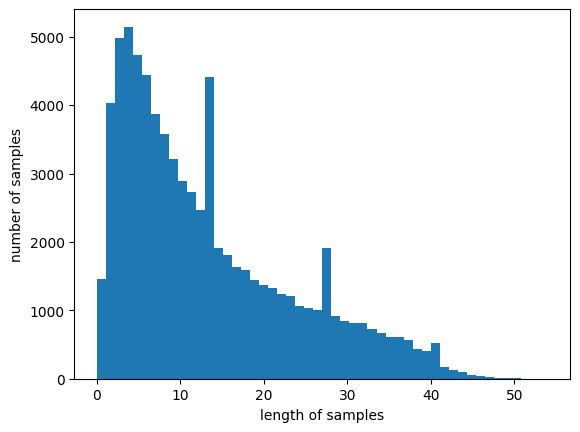

In [27]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [28]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [29]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 100.0


In [30]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [32]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dropout(0.5))  # Dropout 레이어 추가
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
235/235 [==============================] - ETA: 0s - loss: 0.5407 - acc: 0.7230
Epoch 1: val_acc improved from -inf to 0.78083, saving model to best_model.h5
235/235 [==============================] - 129s 523ms/step - loss: 0.5407 - acc: 0.7230 - val_loss: 0.4661 - val_acc: 0.7808
Epoch 2/15
235/235 [==============================] - ETA: 0s - loss: 0.3905 - acc: 0.8292
Epoch 2: val_acc did not improve from 0.78083
235/235 [==============================] - 123s 522ms/step - loss: 0.3905 - acc: 0.8292 - val_loss: 0.4691 - val_acc: 0.7806
Epoch 3/15
235/235 [==============================] - ETA: 0s - loss: 0.3216 - acc: 0.8643
Epoch 3: val_acc did not improve from 0.78083
235/235 [==============================] - 121s 514ms/step - loss: 0.3216 - acc: 0.8643 - val_loss: 0.5121 - val_acc: 0.7741
Epoch 4/15
235/235 [==============================] - ETA: 0s - loss: 0.2612 - acc: 0.8927
Epoch 4: val_acc did not improve from 0.78083
235/235 [==============================] - 12

In [33]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

781/781 [==============================] - 32s 40ms/step - loss: 0.4665 - acc: 0.7827
테스트 정확도: 0.7827


In [34]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dropout(0.5))  # Dropout 레이어 추가
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=128, validation_split=0.2)

Epoch 1/15
469/469 [==============================] - ETA: 0s - loss: 0.5117 - acc: 0.7434
Epoch 1: val_acc improved from -inf to 0.77943, saving model to best_model.h5
469/469 [==============================] - 164s 340ms/step - loss: 0.5117 - acc: 0.7434 - val_loss: 0.4630 - val_acc: 0.7794
Epoch 2/15
469/469 [==============================] - ETA: 0s - loss: 0.3756 - acc: 0.8366
Epoch 2: val_acc improved from 0.77943 to 0.77956, saving model to best_model.h5
469/469 [==============================] - 147s 313ms/step - loss: 0.3756 - acc: 0.8366 - val_loss: 0.4796 - val_acc: 0.7796
Epoch 3/15
469/469 [==============================] - ETA: 0s - loss: 0.2955 - acc: 0.8783
Epoch 3: val_acc did not improve from 0.77956
469/469 [==============================] - 158s 337ms/step - loss: 0.2955 - acc: 0.8783 - val_loss: 0.5299 - val_acc: 0.7699
Epoch 4/15
469/469 [==============================] - ETA: 0s - loss: 0.2320 - acc: 0.9053
Epoch 4: val_acc did not improve from 0.77956
469/469 [=

In [35]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f"% (loaded_model.evaluate(X_test, y_test)[1]))

781/781 [==============================] - 32s 40ms/step - loss: 0.4756 - acc: 0.7832
테스트 정확도: 0.7832
